In [335]:
from feature_extraction_pipeline.open_data_marine_weather.core import MarineWeatherExtractor
from feature_extraction_pipeline.open_data_raw_material_price.core import RawMaterialPriceExtractor
from feature_extraction_pipeline.open_data_terrestrial_weather.core import TerrestrialWeatherExtractor
import pandas as pd
import numpy as np



def load_data(date: str):
    price, p_key = RawMaterialPriceExtractor(date=date).process()
    t_weather, t_key = TerrestrialWeatherExtractor(date=date).process()
    m_weather, m_key = MarineWeatherExtractor(date=date).process()

    # combine data
    weather = pd.merge(
        t_weather.groupby(["일시"]).mean(),
        m_weather.groupby(["일시"]).mean(),
        how='inner', left_on=t_key, right_on=m_key
    ).reset_index()

    return pd.merge(
        price, weather, 
        how="left", left_on=p_key, right_on=t_key
    ).drop("일시", axis=1).astype(dtype={"조사일자": "datetime64"})

data201908 = load_data("201908")
data201907 = load_data("201907")

dataset = data201908.append(data201907).sort_values(by="조사일자", ascending=True)

2020-03-30 10:20:59:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 10:20:59:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 10:21:00:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201908.csv in s3 'production-bobsim'
2020-03-30 10:21:02:manager:<INFO> 1 files is loaded from public_data/open_data_raw_material_price/process/csv/201907.csv in s3 'production-bobsim'
2020-03-30 10:21:02:manager:<INFO> 1 files is loaded from public_data/open_data_terrestrial_weather/process/csv/201907.csv in s3 'production-bobsim'
2020-03-30 10:21:03:manager:<INFO> 1 files is loaded from public_data/open_data_marine_weather/process/csv/201907.csv in s3 'production-bobsim'


In [336]:
filled = dataset.fillna(0)

## adjust train volume fixing test last one day

In [363]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import functools


reverse_list = reverse_series.tolist()

def customized_rmse(y, y_pred):
    error = y - y_pred
    def penalize(x):
        if x > 0:
            # if y > y_pred, penalize 10%
            return x * 1.1
        else:
            return x
    X = np.vectorize(penalize)(error)
    return np.sqrt(np.square(X).mean())

def split_xy(df: pd.DataFrame):
    # print(df.조사일자.drop_duplicates())
    return df.drop(columns=["당일조사가격", "조사일자"]), df["당일조사가격"]

def get_score(train, test):
    x_train, y_train = split_xy(train)
    x_test, y_test = split_xy(test)
    
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_train)
    
    r_pred = np.expm1(y_pred)
    r_test = np.expm1(y_train)
    return customized_rmse(r_test, r_pred)

def adjust_train_volume(x, day, df: pd.DataFrame):
    train = df[(x <= df.조사일자.dt.date) & (df.조사일자.dt.date < day)]
    test = df[df.조사일자.dt.date >= day]
    return get_score(train, test)


In [368]:
def find_train_test(i, df):
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+i:]))
    pd.Series(score_list, index=reverse_list[standard_index+i:]).plot()
    print(score_list)


1
[525.2271430934089, 522.9794281432879, 520.5800518820967, 520.278192613761, 520.9911769169225, 522.2463709226676, 524.0949259188338, 524.6787248838468, 523.866550581565, 524.7178500850224, 523.8434323840968]
2
[522.4901987235027, 520.0861830392499, 519.6266187212798, 520.9471035452727, 521.8714904906118, 523.9671505481663, 524.6347468485878, 524.9906321205505, 524.3953317391067, 523.6416421548621]
3
[521.4216764248847, 520.5698739089945, 521.6473897018863, 525.7019196698676, 564.9284454798595, 525.3495916661943, 524.9440259299201, 524.8432361655429, 523.7287462365681]
4
[517.5790915126535, 519.1663909360369, 520.2582463856317, 522.4714455506564, 523.2647079642621, 522.7541009156554, 522.7343537997496, 521.8462914734621]


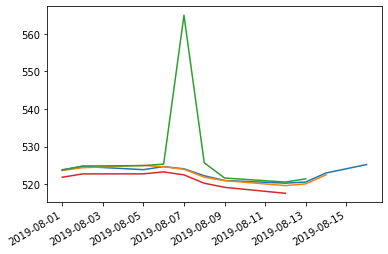

In [369]:
for i in range(1,5):
    print(i)
    find_train_test(i, data201908)

1
2
3
4


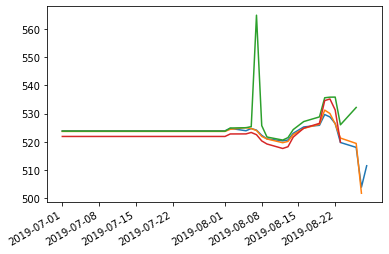

In [365]:
for i in range(1,5):
    print(i)
    standard_index = i
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+1:]))
    pd.Series(score_list, index=reverse_list[standard_index+1:]).plot()


5
6
7
8
9


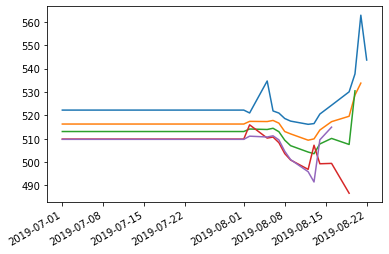

In [367]:
for i in range(5,10):
    print(i)
    standard_index = i
    standard_day = reverse_list[i]
    score_list = list(map(functools.partial(adjust_train_volume, day=standard_day, df=data201908), reverse_list[standard_index+1:]))
    pd.Series(score_list, index=reverse_list[standard_index+1:]).plot()


## Grid Search for ElasticNet

In [373]:
def train_test(df, index):
    i = index
    reverse_list = df.조사일자.drop_duplicates().sort_values(ascending=False).tolist()
    
    return df[df.조사일자.dt.date < reverse_list[i]], df[df.조사일자.dt.date >= reverse_list[i]]

train, test = train_test(filled, 14)
X_train, Y_train = split_xy(train)
X_test, Y_test = split_xy(test)

train1, test1 = train_test(data201908, 7)
X_train1, Y_train1 = split_xy(train1)
X_test1, Y_test1 = split_xy(test1)

train2, test2 = train_test(data201907, 7)
X_train2, Y_train2 = split_xy(train2)
X_test2, Y_test2 = split_xy(test2)

In [347]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_squared_error


In [391]:
def grid_search(X_train, Y_train, X_test, Y_test):
    # Use grid search to tune the parameters:
    params ={
                "max_iter": [1, 5, 10, 50, 100, 500, 1000],
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                "l1_ratio": np.arange(0.0, 1.0, 0.1)
            }

    eNet = ElasticNet()
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(eNet, params, scoring=make_scorer(customized_rmse, greater_is_better=False), cv=tscv.split(X_train))
    grid.fit(X_train, Y_train)
    Y_pred = grid.predict(X_test)
    r_pred = np.expm1(Y_pred)
    r_test = np.expm1(Y_test)
    print(customized_rmse(r_test, r_pred))
    return grid

In [392]:
grid1 = grid_search(X_train1, Y_train1, X_test1, Y_test1)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125.46536745891646, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 248.54710233955774, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 372.6813159231018, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.20790681244813, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.8291602928151, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.122530494990016, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.00954568439064, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.2660025831306, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.537336459968003, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.579216216008, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.9075087288341, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.055791835658795, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.6126656127896, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357.7793561867, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.001228900024728, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.259279554293627, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.75611798693745, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.41677307746613, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.6895693298018, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1005.8227995601374, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.39671895996895, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.13271550064985, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 809.0531534424686, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1268.8540375953153, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might 

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.4586337917732, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1119.5123190770453, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.596281080983715, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3331.437114491313, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4966.388574901806, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678.0511036690011, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.56743000308325, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.57661939017066, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2446.485366967727, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6070.859930011838, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9063.487946257983, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3056.8628095029826, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6649.738523876012, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9930.860462704652, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3348.867948502246, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might wa

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6721.757512828394, tolerance: 1.3445122588114393
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10038.723791801083, tolerance: 2.007998097175498
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3385.036585057902, tolerance: 0.6770844179836649
  positive)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might w

594.8517841261104


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.96265274485205, tolerance: 2.661601832948214
  positive)


In [320]:
ela = grid.get_params()["estimator"]
ela

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [321]:
grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.0, 'max_iter': 1000}

In [322]:
elastic_net = grid.best_estimator_
elastic_net

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [381]:

def test_estimator(X_train, Y_train, X_test, Y_test):
    elastic_net = grid1.best_estimator_
    elastic_net.fit(X_train, Y_train)
    print(elastic_net.score(X_train, Y_train), elastic_net.score(X_test, Y_test))
    Y_pred = elastic_net.predict(X_test)
    print(r2_score(Y_test,Y_pred))
    r_pred = np.expm1(Y_pred)
    r_test = np.expm1(Y_test)
    print(r_pred, r_test)
    print(mean_squared_error(r_test, r_pred, squared=False))
    return elastic_net

# ela = test_estimator(X_train, Y_train, X_test, Y_test) 
# plot_coef(ela)

ela1 = test_estimator(X_train1, Y_train1, X_test1, Y_test1) 
ela2 = test_estimator(X_train2, Y_train2, X_test2, Y_test2) 

# Y_pred = elastic_net.predict(X_test)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360.96265274485205, tolerance: 2.661601832948214
  positive)


0.972646337748365 0.9612203858483603
0.9612203858483603
[ 222.90643035  975.77237226 1227.10656905 ...  622.17868112  801.98097293
 1210.68456991] 25160    238.00000
25161    870.00000
25162    990.00000
25163   1320.00000
25164   1050.00000
           ...    
40507   1566.00000
40508   1166.00000
40509    714.00000
40510   1058.00000
40511   2016.66667
Name: 당일조사가격, Length: 15352, dtype: float64
554.2189751579393
0.9761623465530874 0.9649340310793422
0.9649340310793422
[ 234.31988725 1008.65130784 1364.01994571 ...  622.89551833  844.45799081
 2595.21937328] 26734    258.00000
26735   1450.00000
26736   1050.00000
26737   1120.00000
26738   1120.00000
           ...    
42185   1566.00000
42186   1166.00000
42187    714.00000
42188   1058.00000
42189   2383.33333
Name: 당일조사가격, Length: 15456, dtype: float64
549.3679262129293


C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.5405307036268, tolerance: 3.01656320582926
  positive)


In [388]:
import seaborn as sns
def plot_coef(model, X_train):
    coef = pd.Series(model.coef_, index=X_train.columns)
    coef_sort = coef.sort_values(ascending=False)
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    return coef_sort

품목명_수박수박수박(일반)일반       2.58821
품목명_한우쇠고기안심안심          2.18445
품목명_한우쇠고기등심한우등심        1.99201
품목명_포도포도거봉거봉           1.92981
품목명_레몬레몬레몬(수입)수입       1.76361
                        ...   
품목명_감자감자수미수미          -1.73316
품목명_열무열무열무(일반)일반      -1.87884
품목명_배추얼갈이배추얼갈이배추일반    -1.89022
품목명_양파양파기타양파(일반)      -2.20527
품목명_미나리미나리미나리(일반)일반   -3.33811
Length: 150, dtype: float64

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44648 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48177 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49353 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48260 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49455 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49569 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45712 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54644 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

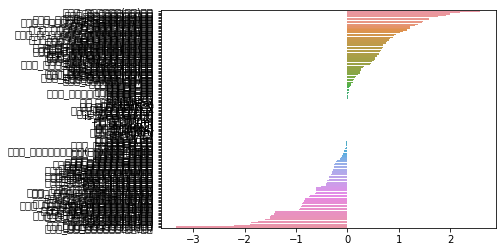

In [389]:
plot_coef(ela1, X_train1)

품목명_수박수박수박(일반)일반       2.58821
품목명_한우쇠고기안심안심          2.18445
품목명_한우쇠고기등심한우등심        1.99201
품목명_포도포도거봉거봉           1.92981
품목명_메론멜론네트계일반          1.76361
                        ...   
품목명_감자감자수미수미          -1.73316
품목명_열무열무열무(일반)일반      -1.87884
품목명_배추얼갈이배추얼갈이배추일반    -1.89022
품목명_양파양파기타양파(일반)      -2.20527
품목명_미나리미나리미나리(일반)일반   -3.33811
Length: 150, dtype: float64

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52380 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50672 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47308 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44405 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

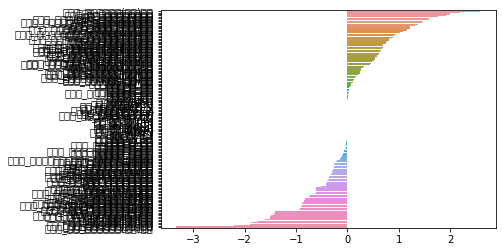

In [390]:
plot_coef(ela2, X_train2)

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib

C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48521 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47788 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\jinho\Anaconda3\envs\BOBSIM\lib\site-packages\matplotlib\backends\

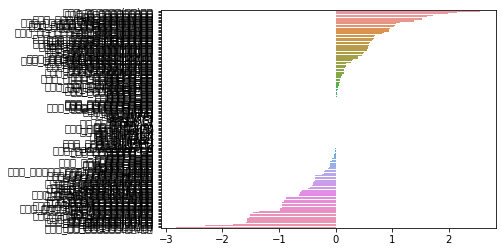

In [256]:
pd.options.display.float_format = '{:.5f}'.format
   
   
l_coef = plot_coef(elastic_net)

In [257]:
final = l_coef.reset_index().rename(columns={"index": "col"})
print(final)
m_list = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '최대 풍속(m/s)', '평균 풍속(m/s)', '최소 상대습도(pct)', '평균 상대습도(pct)', '합계 일조시간(hr)', '강수 계속시간(hr)', '일강수량(mm)']

def func(x):
    print(final[final.col == x])
    return None

list(map(func , m_list))

                     col        0
0       품목명_수박수박수박(일반)일반  2.55618
1          품목명_한우쇠고기안심안심  2.14059
2        품목명_한우쇠고기등심한우등심  1.98793
3          품목명_메론멜론네트계일반  1.71417
4           품목명_포도포도거봉거봉  1.61538
..                   ...      ...
148     품목명_우유우유우유(일반)일반 -1.57293
149         품목명_벼쌀일반계일반계 -1.58411
150         품목명_감자감자수미수미 -1.81007
151     품목명_양파양파기타양파(일반) -2.30796
152  품목명_미나리미나리미나리(일반)일반 -2.82025

[153 rows x 2 columns]
         col       0
76  평균기온(°C) 0.00000
         col       0
77  최저기온(°C) 0.00000
         col        0
79  최고기온(°C) -0.00000
           col       0
83  최대 풍속(m/s) 0.00000
Empty DataFrame
Columns: [col, 0]
Index: []
             col       0
72  최소 상대습도(pct) 0.00000
Empty DataFrame
Columns: [col, 0]
Index: []
            col       0
86  합계 일조시간(hr) 0.00000
            col        0
89  강수 계속시간(hr) -0.00000
         col       0
91  일강수량(mm) 0.00000


[None, None, None, None, None, None, None, None, None, None]